# Data loading and preprocessing

In [1]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
folders = {
    'demented': 1,
    'non_demented': 0
}

data = []
base_path = 'Aug_OASIS'

# Collecting image file paths and labels
for folder, label in folders.items():
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            data.append({
                'file_path': os.path.join(folder_path, file),
                'label': label
            })

df = pd.DataFrame(data)

print(df.head(5))
print(df.shape)
print(df['label'].value_counts())


                                           file_path  label
0  Aug_OASIS/demented/aug_33835_OAS1_0039_MR1_mpr...      1
1  Aug_OASIS/demented/aug_58765_aug_47286_OAS1_02...      1
2     Aug_OASIS/demented/OAS1_0023_MR1_mpr-3_127.jpg      1
3  Aug_OASIS/demented/aug_21481_OAS1_0335_MR1_mpr...      1
4  Aug_OASIS/demented/aug_55549_aug_41841_aug_247...      1
(134444, 2)
label
1    67222
0    67222
Name: count, dtype: int64


In [3]:
# Define the dataset class
class SimpleMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.long)
        return image, label

In [4]:
# Define transformations
transformations = transforms.Compose([
    transforms.Resize(50),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize((0.1266,), (0.1600,))  # Normalization
])

In [5]:
# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [6]:
# Create datasets and DataLoader objects
train_dataset = SimpleMRIDataset(train_df, transform=transformations)
val_dataset = SimpleMRIDataset(val_df, transform=transformations)
test_dataset = SimpleMRIDataset(test_df, transform=transformations)

In [7]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Print the number of images in each dataset
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")


Number of images in the training dataset: 107555
Number of images in the validation dataset: 13444
Number of images in the test dataset: 13445


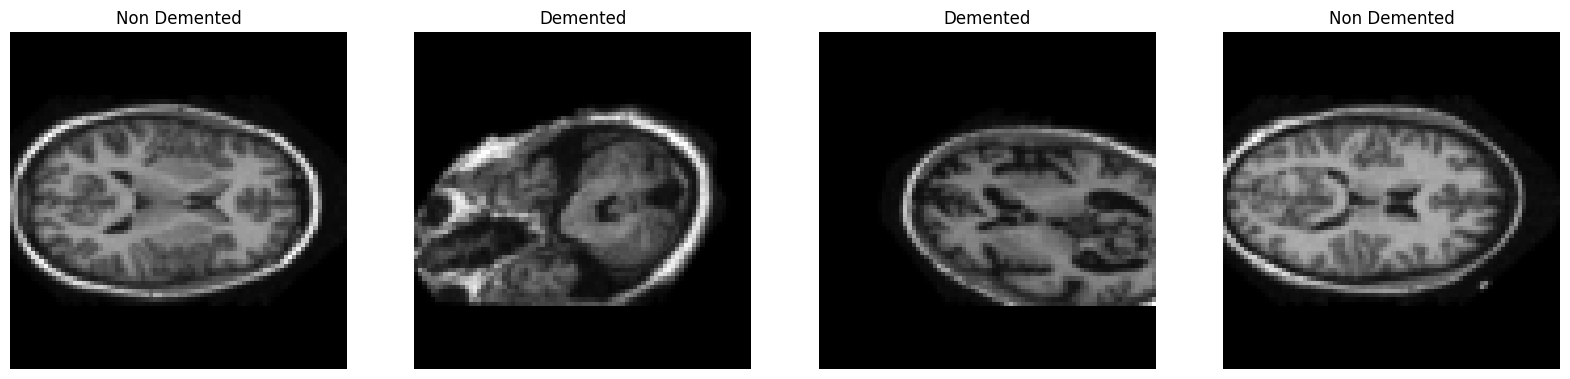

In [9]:
def show_images_with_labels(loader, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    found_non_demented = 0
    found_demented = 0
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            if (label == 0 and found_non_demented < num_images // 2) or (label == 1 and found_demented < num_images // 2):
                ax = axes[found_non_demented + found_demented]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                ax.imshow(img * 0.1266 + 0.1600, cmap='gray')  # Unnormalize
                label_text = 'Non Demented' if label == 0 else 'Demented'
                ax.set_title(label_text)
                ax.axis('off')
                if label == 0:
                    found_non_demented += 1
                else:
                    found_demented += 1
            if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
                break
        if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
            break

show_images_with_labels(train_loader, 4)


# Model

In [10]:
import jax

from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
#from quantum_transformers.quantum_layer import get_circuit

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [11]:
for d in jax.devices():
    print(d, d.device_kind)

TFRT_CPU_0 cpu


In [12]:
model = VisionTransformer(
    num_classes=2,  # Keep binary classification
    patch_size=8,
    hidden_size=4,
    num_heads=2,
    num_transformer_blocks=2,
    mlp_hidden_size=2,
    # quantum_attn_circuit=get_circuit(),
    # quantum_mlp_circuit=get_circuit(),
    #pos_embedding='learn'  # Positional embedding
)

In [13]:
num_classes = 2  # binary classification
num_epochs = 30  # number of epochs

# Call the train_and_evaluate function with the adjusted parameters
test_loss, test_auc, test_fpr, test_tpr, all_logits, all_labels = train_and_evaluate(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    test_dataloader=test_loader, 
    num_classes=num_classes,
    num_epochs=num_epochs,
)


{'params': {'Conv_0': {'bias': (4,), 'kernel': (8, 8, 1, 4)}, 'Dense_0': {'bias': (2,), 'kernel': (4, 2)}, 'LayerNorm_0': {'bias': (4,), 'scale': (4,)}, 'TransformerBlock_0': {'FeedForward_0': {'Dense_0': {'bias': (2,), 'kernel': (4, 2)}, 'Dense_1': {'bias': (4,), 'kernel': (2, 4)}}, 'LayerNorm_0': {'bias': (4,), 'scale': (4,)}, 'LayerNorm_1': {'bias': (4,), 'scale': (4,)}, 'MultiHeadSelfAttention_0': {'Dense_0': {'bias': (4,), 'kernel': (4, 4)}, 'Dense_1': {'bias': (4,), 'kernel': (4, 4)}, 'Dense_2': {'bias': (4,), 'kernel': (4, 4)}, 'Dense_3': {'bias': (4,), 'kernel': (4, 4)}}}, 'TransformerBlock_1': {'FeedForward_0': {'Dense_0': {'bias': (2,), 'kernel': (4, 2)}, 'Dense_1': {'bias': (4,), 'kernel': (2, 4)}}, 'LayerNorm_0': {'bias': (4,), 'scale': (4,)}, 'LayerNorm_1': {'bias': (4,), 'scale': (4,)}, 'MultiHeadSelfAttention_0': {'Dense_0': {'bias': (4,), 'kernel': (4, 4)}, 'Dense_1': {'bias': (4,), 'kernel': (4, 4)}, 'Dense_2': {'bias': (4,), 'kernel': (4, 4)}, 'Dense_3': {'bias': (4,)

Epoch   1/30: 100%|██████████| 6723/6723 [09:12<00:00, 12.17batch/s, Loss = 0.4305, AUC = 89.0523%]


Epoch 1 completed. Validation Loss: 0.4305, Validation AUC: 89.0523%


Epoch   2/30: 100%|██████████| 6723/6723 [08:54<00:00, 12.58batch/s, Loss = 0.3716, AUC = 91.7155%]


Epoch 2 completed. Validation Loss: 0.3716, Validation AUC: 91.7155%


Epoch   3/30: 100%|██████████| 6723/6723 [08:53<00:00, 12.59batch/s, Loss = 0.3540, AUC = 92.3928%]


Epoch 3 completed. Validation Loss: 0.3540, Validation AUC: 92.3928%


Epoch   4/30: 100%|██████████| 6723/6723 [09:02<00:00, 12.38batch/s, Loss = 0.3787, AUC = 93.4979%]


Epoch 4 completed. Validation Loss: 0.3787, Validation AUC: 93.4979%


Epoch   5/30: 100%|██████████| 6723/6723 [08:56<00:00, 12.53batch/s, Loss = 0.3494, AUC = 93.7482%]


Epoch 5 completed. Validation Loss: 0.3494, Validation AUC: 93.7482%


Epoch   6/30: 100%|██████████| 6723/6723 [08:52<00:00, 12.62batch/s, Loss = 0.3546, AUC = 93.9706%]


Epoch 6 completed. Validation Loss: 0.3546, Validation AUC: 93.9706%


Epoch   7/30: 100%|██████████| 6723/6723 [07:58<00:00, 14.04batch/s, Loss = 0.3481, AUC = 93.9872%]


Epoch 7 completed. Validation Loss: 0.3481, Validation AUC: 93.9872%


Epoch   8/30: 100%|██████████| 6723/6723 [07:40<00:00, 14.61batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 8 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch   9/30: 100%|██████████| 6723/6723 [08:00<00:00, 13.99batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 9 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  10/30: 100%|██████████| 6723/6723 [08:51<00:00, 12.66batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 10 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  11/30: 100%|██████████| 6723/6723 [08:31<00:00, 13.15batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 11 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  12/30: 100%|██████████| 6723/6723 [08:54<00:00, 12.59batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 12 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  13/30: 100%|██████████| 6723/6723 [08:54<00:00, 12.57batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 13 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  14/30: 100%|██████████| 6723/6723 [08:43<00:00, 12.83batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 14 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  15/30: 100%|██████████| 6723/6723 [08:58<00:00, 12.48batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 15 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  16/30: 100%|██████████| 6723/6723 [08:46<00:00, 12.77batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 16 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  17/30: 100%|██████████| 6723/6723 [08:46<00:00, 12.78batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 17 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  18/30: 100%|██████████| 6723/6723 [08:44<00:00, 12.83batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 18 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  19/30: 100%|██████████| 6723/6723 [07:34<00:00, 14.79batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 19 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  20/30: 100%|██████████| 6723/6723 [07:31<00:00, 14.89batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 20 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  21/30: 100%|██████████| 6723/6723 [08:39<00:00, 12.94batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 21 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  22/30: 100%|██████████| 6723/6723 [08:43<00:00, 12.84batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 22 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  23/30: 100%|██████████| 6723/6723 [10:33<00:00, 10.61batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 23 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  24/30: 100%|██████████| 6723/6723 [08:07<00:00, 13.79batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 24 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  25/30: 100%|██████████| 6723/6723 [07:40<00:00, 14.60batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 25 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  26/30: 100%|██████████| 6723/6723 [07:36<00:00, 14.72batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 26 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  27/30: 100%|██████████| 6723/6723 [07:30<00:00, 14.91batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 27 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  28/30: 100%|██████████| 6723/6723 [07:26<00:00, 15.04batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 28 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  29/30: 100%|██████████| 6723/6723 [07:25<00:00, 15.10batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 29 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%


Epoch  30/30: 100%|██████████| 6723/6723 [07:25<00:00, 15.09batch/s, Loss = 0.3520, AUC = 93.9602%]


Epoch 30 completed. Validation Loss: 0.3520, Validation AUC: 93.9602%
Total training time = 15178.75s, best validation AUC = 93.9872% at epoch 7
Total training time: 15182.22 seconds
Training Losses: []
Training AUCs: []
Validation Losses: [Array(0.43048543, dtype=float32), Array(0.37160438, dtype=float32), Array(0.353953, dtype=float32), Array(0.3786837, dtype=float32), Array(0.34938762, dtype=float32), Array(0.35464227, dtype=float32), Array(0.348149, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224, dtype=float32), Array(0.35198224

Testing: 100%|██████████| 841/841 [00:47<00:00, 17.86batch/s, Loss = 0.3440, AUC = 94.0981%]


In [14]:
import pickle
with open('qtrans_oasis.pkl', 'wb') as f:
    pickle.dump((test_fpr, test_tpr, test_auc / 100), f)

# Metrics

In [15]:
from sklearn.metrics import classification_report

# Assuming binary classification with logits as probabilities
predicted_labels = (all_logits > 0.5).astype(int)

# For binary classification with raw scores or multi-class classification
# predicted_labels = np.argmax(all_logits, axis=1)

true_labels = all_labels

print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.77      0.97      0.86      6723
           1       0.96      0.70      0.81      6722

    accuracy                           0.84     13445
   macro avg       0.86      0.84      0.83     13445
weighted avg       0.86      0.84      0.83     13445



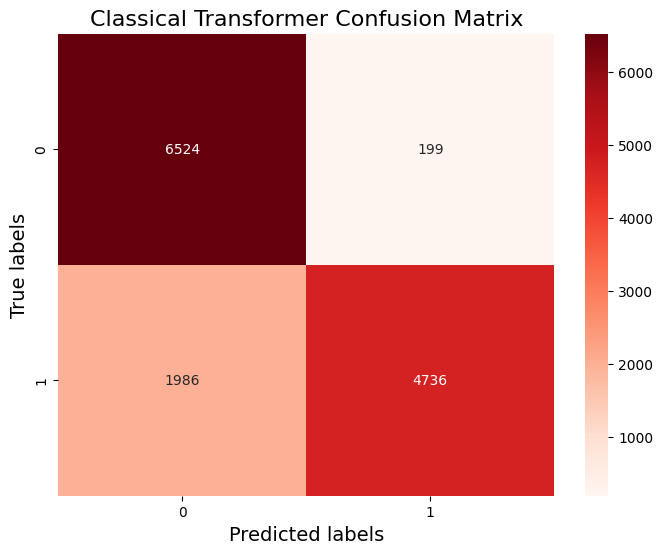

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Assuming you already have predicted_labels and true_labels from your previous code
conf_matrix = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(8, 6))  # Set the size of the figure

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', ax=ax)

# Labels, title, and ticks
label_font = {'size':'14'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Classical Transformer Confusion Matrix', fontdict={'size':16})  # Adjust to fit
ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit

# Save the figure
plt.savefig('trans_oasis_confusion_matrix.png')
plt.show()


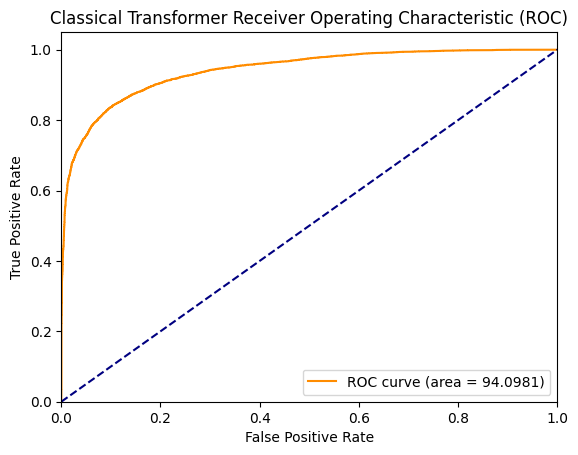

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve (area = %0.4f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classical Transformer Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.savefig('trans_oasis_roc_curve.png')
plt.show()
